In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [24]:
train = pd.read_csv('train.tsv', sep='\t')
print("Sentiment Count")
print(train.Sentiment.value_counts())
train.sample(20)

Sentiment Count
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


,PhraseId,SentenceId,Phrase,Sentiment
17338,17339,752,", Minac drains his movie of all individuality",2
50147,50148,2463,grows boring despite the scenery .,1
6676,6677,266,of John Woo bullet ballet,2
61730,61731,3120,of older movies,2
37918,37919,1803,really more,2
120814,120815,6465,This is n't a movie ; it 's a symptom,0
116400,116401,6207,The entire point of a shaggy dog story,1
67822,67823,3444,understands the grandness of romance,4
26035,26036,1191,None of this has the suavity or classical fami...,2
60154,60155,3034,Poignant if familiar story of a young person,3


## 1. 数据预处理
1. 统计单词频率并保留频率最高的2000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [25]:
# 探索阶段，可放开以下注释，仅使用头1000行数据
# train = train.head(1000)
top_k_words = 1000 # 默认1000, 运行太慢，这里也可以调小

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = str(sentence).split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))

# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 1000


2. 构建基于Bag-of-Words的数据集

In [26]:
# 处理句子数据
def preprocess_sentence(sentence,  word2idx):
    x = np.zeros(len(word2idx)) # BoW不需要不考虑<PAD>
    words = sentence.split()
    words = [w.lower() for w in words]
    for w in words:
        if w in word2idx:
            x[word2idx[w]]+=1
        else:
            x[word2idx['<UNK>']]+=1
    return x
            

# 处理语料库
def extract_BoW_feat(df, word2idx):
    X = []
    for sentence in df.Phrase:
        x = preprocess_sentence(sentence, word2idx)
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y
X,y = extract_BoW_feat(train, word2idx)



# 数据集结构定义
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
# 数据集划分
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]


# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 2. 模型

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# 模型定义
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  # 5 classes for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

# 创建模型实例
model = MLP(len(word2idx), 100, 5)

## 3. 学习准则（策略）

In [28]:
# 交叉熵
criterion = nn.CrossEntropyLoss()

## 4. 优化（算法）

In [29]:
# 随机梯度下降算法SGD的变种
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. 训练过程

In [30]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [] # 训练损失
val_losses = [] # 验证损失
train_accuracies = [] # 训练精度
val_accuracies = [] # 验证精度
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 计算设备使用GPU或CPU（GPU优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练多个回合
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = (train_correct / len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # 打印训练和验证的损失和精度
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/10, Loss: 1.3586, Val Loss: 1.3646, Train Acc: 54.54%, Val Acc: 53.57%
Epoch 2/10, Loss: 1.3339, Val Loss: 1.3673, Train Acc: 56.82%, Val Acc: 53.23%
Epoch 3/10, Loss: 1.3276, Val Loss: 1.3468, Train Acc: 57.39%, Val Acc: 55.08%
Epoch 4/10, Loss: 1.3010, Val Loss: 1.3373, Train Acc: 59.99%, Val Acc: 56.14%
Epoch 5/10, Loss: 1.2847, Val Loss: 1.3333, Train Acc: 61.75%, Val Acc: 56.42%
Epoch 6/10, Loss: 1.2717, Val Loss: 1.3329, Train Acc: 63.12%, Val Acc: 56.46%
Epoch 7/10, Loss: 1.2630, Val Loss: 1.3359, Train Acc: 64.10%, Val Acc: 56.03%
Epoch 8/10, Loss: 1.2551, Val Loss: 1.3350, Train Acc: 64.94%, Val Acc: 56.19%
Epoch 9/10, Loss: 1.2481, Val Loss: 1.3351, Train Acc: 65.73%, Val Acc: 56.33%
Epoch 10/10, Loss: 1.2416, Val Loss: 1.3350, Train Acc: 66.40%, Val Acc: 56.21%


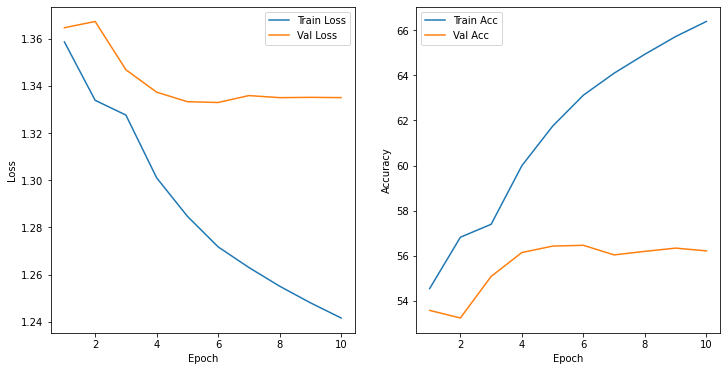

In [31]:
# 对训练和验证集上的损失和精度按照回合数进行可视化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('loss_acc_plot.png')
plt.show()

## 6. 测试
测试结果可提交后查看精度表现
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews

In [32]:
test = pd.read_csv('test.tsv', sep='\t')
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_BoW_feat(test, word2idx)
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)  # 若有GPU，数据移到GPU显存
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.append(predicted.cpu().numpy())
y_test = np.concatenate(all_predicted)
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_BoW_MLP.csv', index=False)

In [33]:
# 查看当前目录下生成的结果和图片文件
!ls

Sentiment_BoW_MLP.csv                 sentiment_wordemb_mlp_gloveinit.ipynb
Sentiment_wordemb_MLP.csv             test.tsv
loss_acc_plot.png                     train.tsv
sentiment_bow_mlp.py                  学号_姓名_sentiment_bow_mlp.ipynb
sentiment_wordemb_mlp.ipynb
